# AI vs Human Text Detection

This notebook builds three classifiers (SVM, Decision Tree, AdaBoost) to detect whether text was written by AI or a human.  
It uses TF-IDF + simple text statistics, hyperparameter tuning via GridSearchCV, and saves ready-to-load pipelines for a Streamlit app.

Author: Khalid Alam, R11821835.

### Imports and Data loadinng

In [1]:
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

import joblib


df = pd.read_excel('../data/AI_vs_huam_train_dataset.xlsx')
print(df.columns.tolist())
df.head()


['essay', 'label']


,essay,label
0,International sports events require the most w...,0
1,Globalisation has become a significant aspect ...,0
2,There is an ever-increasing number of bullying...,0
3,"It is commonly believed, that companies should...",0
4,Despite knowing about the adverse effects of c...,0


### Preprocessing

In [2]:
class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        return X.apply(lambda t: 
            re.sub(r'[^a-z\s]', '',
                  re.sub(r'http\S+', '', str(t).lower())
            ).strip()
        )

class TextStats(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        stats = []
        for doc in X:
            words = doc.split()
            stats.append([
                len(words),
                np.mean([len(w) for w in words]) if words else 0,
                doc.count('.') / max(len(words),1)
            ])
        return np.array(stats)

# combine TF-IDF and text‐stats
features = FeatureUnion([
    ('tfidf', TfidfVectorizer()),
    ('stats', TextStats())
])

# apply preprocessor
df['clean_text'] = CustomPreprocessor().transform(df['essay'])


### Train and Test Split

In [3]:
X = df['clean_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


### Pipelines and parameters

In [4]:
# SVM pipeline + grid
svm_pipe = Pipeline([
    ('clean', CustomPreprocessor()),
    ('feat', features),
    ('clf', SVC(probability=True, random_state=42))
])
svm_param = {
    'feat__tfidf__max_features': [5000, 10000],
    'feat__tfidf__ngram_range': [(1,1), (1,2)],
    'clf__C': [0.1, 1, 10],
    'clf__kernel': ['linear','rbf'],
    'clf__gamma': ['scale','auto']
}

# Decision Tree pipeline + grid
dt_pipe = Pipeline([
    ('clean', CustomPreprocessor()),
    ('feat', features),
    ('clf', DecisionTreeClassifier(random_state=42))
])
dt_param = {
    'feat__tfidf__max_features': [5000, 10000],
    'feat__tfidf__ngram_range': [(1,1), (1,2)],
    'clf__criterion': ['gini','entropy'],
    'clf__max_depth': [10, 20, None],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2]
}

# AdaBoost pipeline + grid
ab_pipe = Pipeline([
    ('clean', CustomPreprocessor()),
    ('feat', features),
    ('clf', AdaBoostClassifier(random_state=42))
])
ab_param = {
    'feat__tfidf__max_features': [5000, 10000],
    'feat__tfidf__ngram_range': [(1,1), (1,2)],
    'clf__n_estimators': [50, 100, 150],
    'clf__learning_rate': [0.5, 1.0]
}


### GRIDSEARCH

In [14]:
print("Starting SVM pipeline search...")
svm_search = GridSearchCV(svm_pipe, svm_param, cv=5, scoring='f1_macro', n_jobs=-1, verbose=2)
svm_search.fit(X_train, y_train)
print(f"SVM done. Best F1 Macro: {svm_search.best_score_:.4f}")
print("SVM Best Params:", svm_search.best_params_)
joblib.dump(svm_search.best_estimator_, '../models/svm_pipeline.pkl')

print("Starting Decision Tree pipeline search...")
dt_search = GridSearchCV(dt_pipe, dt_param, cv=5, scoring='f1_macro', n_jobs=-1, verbose=2)
dt_search.fit(X_train, y_train)
print(f"Decision Tree done. Best F1 Macro: {dt_search.best_score_:.4f}")
print("Decision Tree Best Params:", dt_search.best_params_)
joblib.dump(dt_search.best_estimator_, '../models/decision_tree_pipeline.pkl')

print("Starting AdaBoost pipeline search...")
ab_search = GridSearchCV(ab_pipe, ab_param, cv=5, scoring='f1_macro', n_jobs=-1, verbose=2)
ab_search.fit(X_train, y_train)
print(f"AdaBoost done. Best F1 Macro: {ab_search.best_score_:.4f}")
print("AdaBoost Best Params:", ab_search.best_params_)
joblib.dump(ab_search.best_estimator_, '../models/adaboost_pipeline.pkl')

Starting SVM pipeline search...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
SVM done. Best F1 Macro: 0.9893
SVM Best Params: {'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'linear', 'feat__tfidf__max_features': 5000, 'feat__tfidf__ngram_range': (1, 2)}
Starting Decision Tree pipeline search...
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Decision Tree done. Best F1 Macro: 0.8772
Decision Tree Best Params: {'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'feat__tfidf__max_features': 10000, 'feat__tfidf__ngram_range': (1, 2)}
Starting AdaBoost pipeline search...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
AdaBoost done. Best F1 Macro: 0.9658
AdaBoost Best Params: {'clf__learning_rate': 1.0, 'clf__n_estimators': 150, 'feat__tfidf__max_features': 10000, 'feat__tfidf__ngram_range': (1, 2)}


['../models/adaboost_pipeline.pkl']

### TF-IDF Vectorizer

In [15]:

tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
tfidf_vectorizer.fit(df['clean_text'])
joblib.dump(tfidf_vectorizer, '../models/tfidf_vectorizer.pkl')

['../models/tfidf_vectorizer.pkl']

## Reports and Confusion Matrices


SVM Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       373
           1       0.99      0.99      0.99       373

    accuracy                           0.99       746
   macro avg       0.99      0.99      0.99       746
weighted avg       0.99      0.99      0.99       746



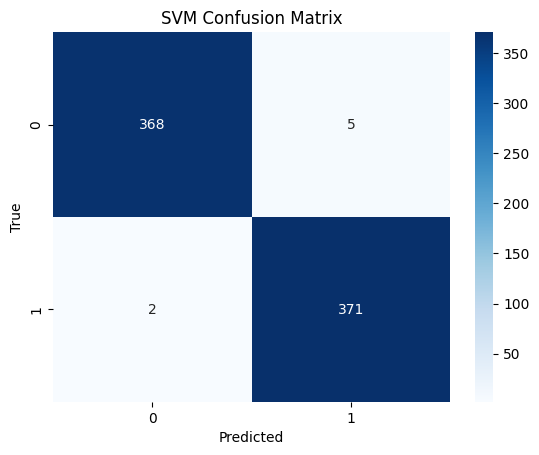


Decision Tree Classification Report
              precision    recall  f1-score   support

           0       0.89      0.90      0.89       373
           1       0.89      0.89      0.89       373

    accuracy                           0.89       746
   macro avg       0.89      0.89      0.89       746
weighted avg       0.89      0.89      0.89       746



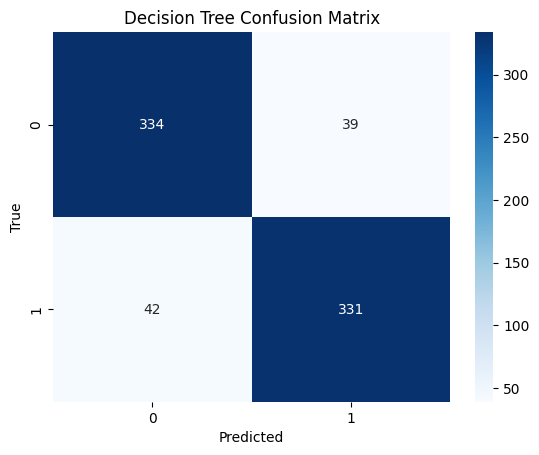


AdaBoost Classification Report
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       373
           1       0.98      0.96      0.97       373

    accuracy                           0.97       746
   macro avg       0.97      0.97      0.97       746
weighted avg       0.97      0.97      0.97       746



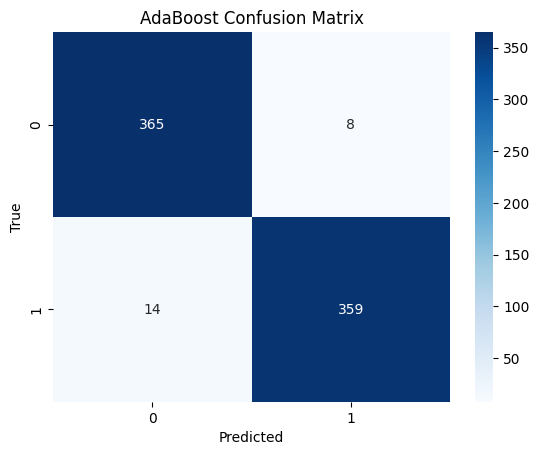

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
models = {
    'SVM': joblib.load('../models/svm_model.pkl'),
    'Decision Tree': joblib.load('../models/decision_tree_model.pkl'),
    'AdaBoost': joblib.load('../models/adaboost_model.pkl')
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\n{name} Classification Report")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


### Model Comparison and ROC curves

In [ ]:
# Cell 9 – Model Comparison & ROC Data Saving

from sklearn.metrics import accuracy_score, f1_score, roc_curve
from sklearn.preprocessing import LabelBinarizer
import pandas as pd
import joblib

# load your test split (X_test, y_test) and models
models = {
    'SVM': joblib.load('../models/svm_model.pkl'),
    'Decision Tree': joblib.load('../models/decision_tree_model.pkl'),
    'AdaBoost': joblib.load('../models/adaboost_model.pkl')
}

# Build and save the comparison table
summary = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    summary.append([
        name,
        accuracy_score(y_test, y_pred),
        f1_score(y_test, y_pred, average='macro'),
        f1_score(y_test, y_pred, average='weighted')
    ])
comparison_df = pd.DataFrame(
    summary,
    columns=['Model', 'Accuracy', 'F1 Macro', 'F1 Weighted']
)
comparison_df.to_csv('../models/model_comparison.csv', index=False)

# Build and save the ROC‐Data
lb = LabelBinarizer().fit(y_test)
y_bin = lb.transform(y_test).ravel()

roc_records = []
for name, model in models.items():
    probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_bin, probs)
    for fp, tp in zip(fpr, tpr):
        roc_records.append({'Model': name, 'FPR': fp, 'TPR': tp})

roc_df = pd.DataFrame(roc_records)
roc_df.to_csv('../models/roc_data.csv', index=False)

# Display
comparison_df


,Model,Accuracy,F1 Macro,F1 Weighted
0,SVM,0.990617,0.990616,0.990616
1,Decision Tree,0.891421,0.891419,0.891419
2,AdaBoost,0.970509,0.970507,0.970507
